# Logistic Regression - Predicting Employee Churn

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import warnings; warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## Data Exploration

### Reading the data from the source and check its dimensions and columns

In [2]:
data = pd.read_csv('/Users/pranshu/Documents/Work/Projects/eClerx/EmployeeChurn.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))
print(data.dtypes)

(29998, 10)
['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years', 'sales', 'salary']
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object


Output variable is **'left'**
#### **Sales** and **Salary** are object (factor) types. Check the factor level for each

In [3]:
data['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [4]:
data['sales'].unique()

array(['product_mng', 'sales', 'technical', 'hr', 'RandD', 'marketing',
       'support', 'IT', 'management', 'accounting'], dtype=object)

### Checking the output distribution

In [5]:
data['left'].value_counts()

0    22856
1     7142
Name: left, dtype: int64

The data is not skewed. There are roughly 80% employees who left the organisation while 20% are those who did not.

### Plotting crosstabulated data of people in different departments vs the corresponding churn

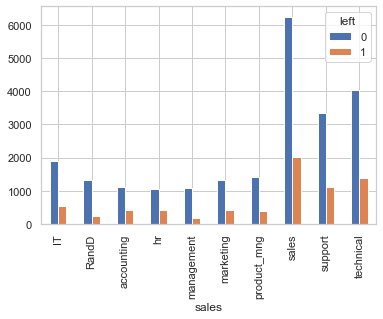

In [6]:
pd.crosstab(data['sales'], data['left']).plot(kind='bar')

In [7]:
crosstab_data = pd.crosstab(data['sales'], data['left'])
ct_percentage = (crosstab_data[1]/crosstab_data[0])*100

ct_percentage

sales
IT             28.616352
RandD          18.168168
accounting     36.234458
hr             41.030534
management     16.883117
marketing      30.992366
product_mng    28.125000
sales          32.437620
support        33.154122
technical      34.453782
dtype: float64

It is clear from the data that most of the churn in happening in the **HR department**, followed by **technical and support departments**

### Analyzing aggregate data for numerical predictors to understand pattern

In [8]:
data.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


### Inferences
1: **Satisfaction level** is 50% more in people who stayed in the organisation vs the ones who left<br>
2: Those who left the organisation **had not received any promotion in the last 5 years**<br>
3: **Average monthly hours spent** in office is marginally more for people who left vs people who stayed<br>
4: **Evaluation score** and **number of projects** did not have much impact on employee churn (values are almost equal)<br>

### Encoding the categorical variables - Sales and Salary

In [9]:
cat_vars=['sales','salary']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
cat_vars=['sales','salary']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [10]:
data_final=data[to_keep]
data_final.columns.values

array(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'left', 'promotion_last_5years', 'sales_IT', 'sales_RandD',
       'sales_accounting', 'sales_hr', 'sales_management',
       'sales_marketing', 'sales_product_mng', 'sales_sales',
       'sales_support', 'sales_technical', 'salary_high', 'salary_low',
       'salary_medium'], dtype=object)

In [11]:
data_final_vars=data_final.columns.values.tolist()
y=['left']
X=[i for i in data_final_vars if i not in y]

### Using Recursive Feature Elimination for feature elimination (Not all features in a regression equation are important)

In [12]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000000000)

rfe = RFE(logreg)
rfe = rfe.fit(data_final[X], data_final[y])
print(rfe.support_)
#print(rfe.ranking_)

vars_rfe = []
for i in range(0, len(rfe.support_)):
    if(rfe.support_[i] == True):
        vars_rfe.append(X[i])

print(vars_rfe)
len(vars_rfe)

[ True  True False False  True  True  True False  True False  True  True
 False False False False False  True  True False]
['satisfaction_level', 'last_evaluation', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'sales_RandD', 'sales_hr', 'sales_management', 'salary_high', 'salary_low']


10

#### Creating data based on the features list obtained from RFE output

In [13]:
X=data_final[vars_rfe]
y=data_final['left']

### Implementing the model

In [14]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.436623
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   left   No. Observations:                29998
Model:                          Logit   Df Residuals:                    29988
Method:                           MLE   Df Model:                            9
Date:                Sat, 25 Jul 2020   Pseudo R-squ.:                  0.2045
Time:                        17:02:50   Log-Likelihood:                -13098.
converged:                       True   LL-Null:                       -16465.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
satisfaction_level       -3.7720      0.060    -62.787      0.000      -3.890      -3.

### Logistic Model Fitting
Splitting the data into 70% **train** and 30% **test**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

### Making predictions using the model fitted above

In [16]:
y_pred = logreg.predict(X_test)

### Model Accuracy

In [18]:
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.766


### Doing Cross Validation with 10 folds on the data

In [19]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=20, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.769


### Confusion Matrix

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6328  507]
 [1603  562]]


### Estimating Precision and Recall

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
test_pranshu = 1

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      6835
           1       0.53      0.26      0.35      2165

    accuracy                           0.77      9000
   macro avg       0.66      0.59      0.60      9000
weighted avg       0.73      0.77      0.73      9000



### ROC and AUC Curve

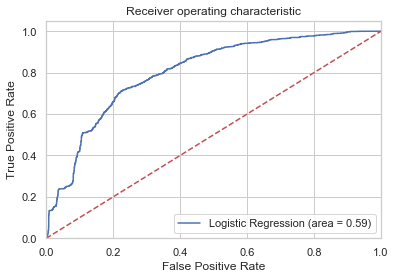

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()